In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#enable IPython to display matplolib graphs
%matplotlib inline

from sklearn import tree


In [2]:
from ML_classes.DTModel import DTModel


2022-03-24 14:46:28.168293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 14:46:28.168309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
#df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
#hh = hh.set_index("tstp")
#hh = hh.resample("H").sum()
#hh = hh.reset_index()

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

/tmp/ipykernel_62947/194026773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


In [5]:
# Initiating the class
DT = DTModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24*2,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
DT.DTModel()

DecisionTreeRegressor()

In [7]:
yhat = DT.predict()
yhat

[0.2706195366940777,
 0.11098441317041971,
 0.07487647045177374,
 0.1835803886539944,
 0.07449638606917817,
 0.05473203782001872,
 0.05473203782001872,
 0.046370201225821264,
 0.0429494474461483,
 0.029266437991143625,
 0.04180919713020518,
 0.03382744208675971,
 0.03496769240270284,
 0.022805016230315063,
 0.05207145280553689,
 0.029646522373739194,
 0.05397187471851475,
 0.5191942358344841,
 0.24059293276958651,
 0.2246294226826956,
 0.04522995090987814,
 0.043709616211339446,
 0.09730140937910221,
 0.024325352344775553,
 0.23109082886838442,
 0.03192702300562544,
 0.025085518278123106,
 0.030786772689682322,
 0.06689471540832828,
 0.07601672359956047,
 0.1303686770369836,
 0.04979095217365064,
 0.053591790335919175,
 0.09920182562839289,
 0.19916380869460257,
 0.29494489187069683,
 0.9228430005979041,
 0.5648042258174604,
 0.14291143334420156,
 0.09122006492126025,
 0.13683010587742114,
 0.3348536557605498,
 0.5343975658288095,
 0.4789053479162253,
 0.12428733824282882,
 0.256556442

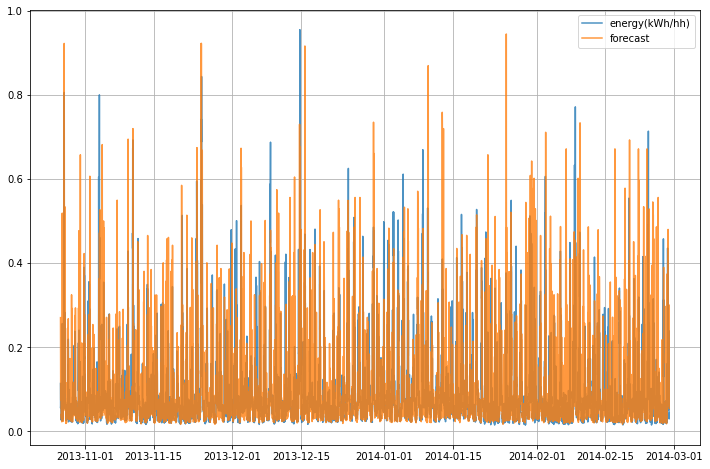

In [9]:
# Defining the lag that we used for training of the model 
lag_model = 48
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = DT.dc.create_X_Y(ts, lag=lag_model)
X = DT.alter_x_shape(X)
# Getting the forecast
yhat = DT.model.predict(X)

yhat = DT.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_62947/1427839267.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


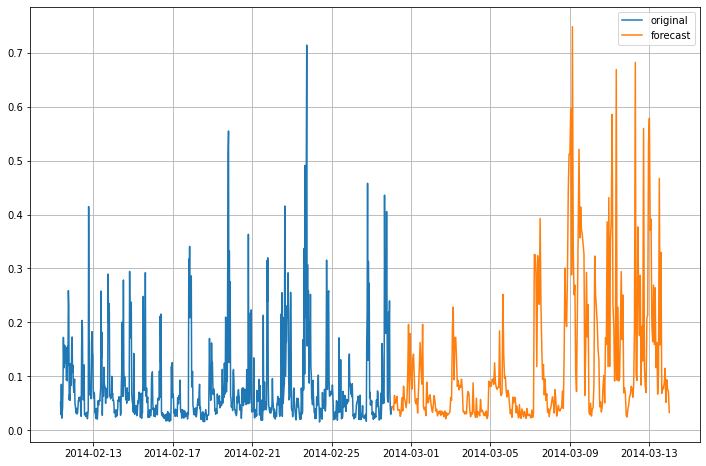

In [12]:
#Forecasting n steps ahead
n_ahead = 168 *2
yhat = DT.predict_n_ahead(n_ahead)
yhat = [y[0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(800).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [ ]:
DT.evaluateMSE()

In [ ]:
DT.evaluateRMSE()

In [ ]:
DT.evaluateMAE()

In [ ]:
DT.evaluateMAPE()

In [ ]:
DT.plot_dt()

In [ ]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    # Initiating the class
    DT = DTModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 24,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15
    )
    #training
    DT.DTModel()
    
    mse.append(DT.evaluateMSE())
    rmse.append(DT.evaluateRMSE())
    mae.append(DT.evaluateMAE())
    mape.append(DT.evaluateMAPE())
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape



In [ ]:
res_df